In [ ]:
import requests
from bs4 import BeautifulSoup
import json
import time
import csv

In [ ]:
class ZillowScraper():
  results = []
  headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-US,en;q=0.9',
        'cache-control': 'max-age=0',
        'cookie': 'zguid=23|%24d14f0059-d03b-4422-9f57-5862fcd13490; _ga=GA1.2.1741285320.1590755697; zjs_user_id=null; zjs_anonymous_id=%22d14f0059-d03b-4422-9f57-5862fcd13490%22; __gads=ID=1050523ba93d593d:T=1590755700:S=ALNI_MZlJJ_xqSbd51oJisV_HY4g017Ehw; _gcl_au=1.1.2000298647.1590755705; KruxPixel=true; _fbp=fb.1.1590755705919.1815197270; _pxvid=d6c5ec75-a1a8-11ea-b8a9-0242ac120009; KruxAddition=true; JSESSIONID=3E7EBDB1F8931DF7D0DE9992546AE0B3; zgsession=1|200e23e0-9534-4d27-931f-caa3de6b483b; _gid=GA1.2.1328942480.1590858452; _gat=1; DoubleClickSession=true; GASession=true; _uetsid=fdde22d5-862a-8a7d-93e4-a16c574edf91; _pin_unauth=YzUyOGQ2OGMtMmQ3YS00NGZkLTg3MmEtOGJlODM1YWMwMTA1; _px3=026336d3721eec42bcdec3278ad2d3ac2014d5e65707b21624fb2e743d9a89be:mq3WRz2RNL5PBIvbYNHCxq5VfXHXy2YKC+8Lqn97pIw8MiKppH7Cx7AjKzbAFi1zcehKGY36aIgsnE9NiPKwlw==:1000:4U1o3ogIQ0KzfyMd2QYEFGDnD1augezy5bJlzEn9ZHE89B2uEIxDg8BmsGj8szPwyIz1Yv15S2V0TV5P+0jCFisfGk92XM4DM7K13GCtNr0HXhNGftVBFxVrCv8ApRphw/Qwj7AcagCh9i6FPiQGLFruxVASJXLsNpFeWimekVY=; AWSALB=ZKAGBcH2BwM6D1bRKOPynbOqyclySGz5U/fZB+wO3MYQ91UR9A5rFVtFsmjOkrMASUJguhtsJRZDM7IlBiWVT/pGw2S0BjxgEZmpFPrBZEqU2lWTE2NMArtecZD2; AWSALBCORS=ZKAGBcH2BwM6D1bRKOPynbOqyclySGz5U/fZB+wO3MYQ91UR9A5rFVtFsmjOkrMASUJguhtsJRZDM7IlBiWVT/pGw2S0BjxgEZmpFPrBZEqU2lWTE2NMArtecZD2; search=6|1593450465587%7Crect%3D40.843698984643765%252C-73.50417109960938%252C40.567821651427245%252C-74.45174190039063%26rid%3D6181%26disp%3Dmap%26mdm%3Dauto%26p%3D2%26z%3D0%26lt%3Dfsbo%26fs%3D1%26fr%3D0%26mmm%3D0%26rs%3D0%26ah%3D0%26singlestory%3D0%26housing-connector%3D0%26abo%3D0%26garage%3D0%26pool%3D0%26ac%3D0%26waterfront%3D0%26finished%3D0%26unfinished%3D0%26cityview%3D0%26mountainview%3D0%26parkview%3D0%26waterview%3D0%26hoadata%3D1%26zillow-owned%3D0%263dhome%3D0%09%096181%09%09%09%09%09%09',
        'sec-fetch-dest': 'document',
        'sec-fetch-mode': 'navigate',
        'sec-fetch-site': 'same-origin',
        'sec-fetch-user': '?1',
        'upgrade-insecure-requests': '1',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36'
    }

  def fetch(self, URL, params):
    response = requests.get(URL, headers=self.headers, params=params)
    #print(response)
    return response

  def parse(self, response):
    content = BeautifulSoup(response, 'lxml')
    #print(content.prettify())
    #dock = content.find('ul',{'class': "photo-cards photo-cards_wow photo-cards_short photo-cards_extra-attribution"})
    dock = content.find('ul',{'class': "photo-cards photo-cards_wow photo-cards_short"})
    #print(dock.prettify())
    for card in dock.contents:
      script = card.find('script', {'type': 'application/ld+json'})
      if script:
        #print(script.prettify())
        script_json = json.loads(script.contents[0])
        #print(script_json)

        self.results.append({
                    'name': script_json['name'],
                    'latitude': script_json['geo']['latitude'],
                    'longitude': script_json['geo']['longitude'],
                    'floorSize': script_json['floorSize']['value'],
                    'url': script_json['url'],
                    'price': card.find('div', {'class': 'list-card-price'}).text
                })
        
    print(self.results)

  def to_csv(self):
        with open('zillow.csv', 'w') as csv_file:
            writer = csv.DictWriter(csv_file, fieldnames=self.results[0].keys())
            writer.writeheader()

            for row in self.results:
                writer.writerow(row)

  def run(self):
    URL = "https://www.zillow.com/homes/Dallas,-TX_rb/"
    
    
    for page in range(1,8):
      params = {
            #'searchQueryState':'{"pagination":{currentPage": %s},"usersSearchTerm":"TX","mapBounds":{"west":-107.18499679687498,"east":-92.96868820312498,"south":23.265356426637354,"north":38.740191306165},"regionSelection":[{"regionId":54,"regionType":2}],"isMapVisible":false,"filterState":{"sort":{"value":"globalrelevanceex"},"ah":{"value":true}},"isListVisible":true,"mapZoom":6}' %page
            #'searchQueryState':'{"pagination":{currentPage": %s},"usersSearchTerm":"NM","mapBounds":{"west":-112.45307045312501,"east":-99.59906654687501,"south":30.37976976541988,"north":37.88116136061692},"regionSelection":[{"regionId":41,"regionType":2}],"isMapVisible":false,"filterState":{"sort":{"value":"globalrelevanceex"},"ah":{"value":true}},"isListVisible":true,"mapZoom":7}' %page
            'searchQueryState': '{"pagination":{currentPage": %s},"usersSearchTerm":"Dallas, TX","mapBounds":{"west":-97.17911912207032,"east":-96.3757438779297,"south":32.579284327866134,"north":33.055930848712755},"regionSelection":[{"regionId":38128,"regionType":6}],"isMapVisible":false,"filterState":{"sort":{"value":"globalrelevanceex"},"ah":{"value":true}},"isListVisible":true,"mapZoom":11}' %page
        }
      res = self.fetch(URL, params)
      self.parse(res.text)
      time.sleep(2)
    
    self.to_csv()

    


if __name__ == '__main__':
  scraper = ZillowScraper()
  scraper.run()

[{'name': '5330 El Torro St, Dallas, TX 75236', 'latitude': 32.686073, 'longitude': -96.9166, 'floorSize': '1,421', 'url': 'https://www.zillow.com/homedetails/5330-El-Torro-St-Dallas-TX-75236/67963415_zpid/', 'price': '$280,900'}, {'name': '2444 Wilma St, Dallas, TX 75241', 'latitude': 32.667534, 'longitude': -96.78064, 'floorSize': '3,061', 'url': 'https://www.zillow.com/homedetails/2444-Wilma-St-Dallas-TX-75241/26822768_zpid/', 'price': '$285,000'}, {'name': '3807 Frank St, Dallas, TX 75210', 'latitude': 32.771214, 'longitude': -96.75046, 'floorSize': '1,697', 'url': 'https://www.zillow.com/homedetails/3807-Frank-St-Dallas-TX-75210/26688624_zpid/', 'price': '$270,000'}, {'name': '2538 Starks Ave, Dallas, TX 75215', 'latitude': 32.749714, 'longitude': -96.75178, 'floorSize': '1,557', 'url': 'https://www.zillow.com/homedetails/2538-Starks-Ave-Dallas-TX-75215/26699344_zpid/', 'price': '$265,000'}, {'name': '5724 Lazy River Dr, Dallas, TX 75241', 'latitude': 32.678005, 'longitude': -96.7

<!DOCTYPE html5>
<html>
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="width=device-width,initial-scale=1" name="viewport"/>
  <script src="https://www.google.com/recaptcha/api.js">
  </script>
  <style type="text/css">
   #submit {
        -webkit-border-radius: 4;
        -moz-border-radius: 4;
        border-radius: 4px;
        font-family: Arial;
        font-size: 16px;
        background: #0c82a5;
        padding: 7px 10px 7px 10px;
        text-decoration: none;
        color: #ffffff;
        border: none;
    }

    #submit:hover {
        background: #3cb0fd;
        text-decoration: none;
    }

    body {
        font-family: Arial,"Helvetica Neue",Helvetica,sans-serif;
        margin: 0;
    }
    div#header {
        height: 59px;
        width: 100%;
        background-color: #fff;
        box-shadow: 0 0 1px rgba(0,0,0,.3);
    }

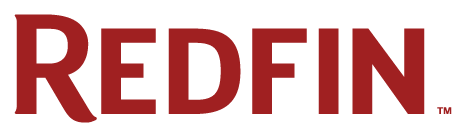

In [ ]:
next_headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-US,en;q=0.9',
        'cache-control': 'max-age=0',
        'cookie': 'zguid=23|%24d14f0059-d03b-4422-9f57-5862fcd13490; _ga=GA1.2.1741285320.1590755697; zjs_user_id=null; zjs_anonymous_id=%22d14f0059-d03b-4422-9f57-5862fcd13490%22; __gads=ID=1050523ba93d593d:T=1590755700:S=ALNI_MZlJJ_xqSbd51oJisV_HY4g017Ehw; _gcl_au=1.1.2000298647.1590755705; KruxPixel=true; _fbp=fb.1.1590755705919.1815197270; _pxvid=d6c5ec75-a1a8-11ea-b8a9-0242ac120009; KruxAddition=true; JSESSIONID=3E7EBDB1F8931DF7D0DE9992546AE0B3; zgsession=1|200e23e0-9534-4d27-931f-caa3de6b483b; _gid=GA1.2.1328942480.1590858452; _gat=1; DoubleClickSession=true; GASession=true; _uetsid=fdde22d5-862a-8a7d-93e4-a16c574edf91; _pin_unauth=YzUyOGQ2OGMtMmQ3YS00NGZkLTg3MmEtOGJlODM1YWMwMTA1; _px3=026336d3721eec42bcdec3278ad2d3ac2014d5e65707b21624fb2e743d9a89be:mq3WRz2RNL5PBIvbYNHCxq5VfXHXy2YKC+8Lqn97pIw8MiKppH7Cx7AjKzbAFi1zcehKGY36aIgsnE9NiPKwlw==:1000:4U1o3ogIQ0KzfyMd2QYEFGDnD1augezy5bJlzEn9ZHE89B2uEIxDg8BmsGj8szPwyIz1Yv15S2V0TV5P+0jCFisfGk92XM4DM7K13GCtNr0HXhNGftVBFxVrCv8ApRphw/Qwj7AcagCh9i6FPiQGLFruxVASJXLsNpFeWimekVY=; AWSALB=ZKAGBcH2BwM6D1bRKOPynbOqyclySGz5U/fZB+wO3MYQ91UR9A5rFVtFsmjOkrMASUJguhtsJRZDM7IlBiWVT/pGw2S0BjxgEZmpFPrBZEqU2lWTE2NMArtecZD2; AWSALBCORS=ZKAGBcH2BwM6D1bRKOPynbOqyclySGz5U/fZB+wO3MYQ91UR9A5rFVtFsmjOkrMASUJguhtsJRZDM7IlBiWVT/pGw2S0BjxgEZmpFPrBZEqU2lWTE2NMArtecZD2; search=6|1593450465587%7Crect%3D40.843698984643765%252C-73.50417109960938%252C40.567821651427245%252C-74.45174190039063%26rid%3D6181%26disp%3Dmap%26mdm%3Dauto%26p%3D2%26z%3D0%26lt%3Dfsbo%26fs%3D1%26fr%3D0%26mmm%3D0%26rs%3D0%26ah%3D0%26singlestory%3D0%26housing-connector%3D0%26abo%3D0%26garage%3D0%26pool%3D0%26ac%3D0%26waterfront%3D0%26finished%3D0%26unfinished%3D0%26cityview%3D0%26mountainview%3D0%26parkview%3D0%26waterview%3D0%26hoadata%3D1%26zillow-owned%3D0%263dhome%3D0%09%096181%09%09%09%09%09%09',
        'sec-fetch-dest': 'document',
        'sec-fetch-mode': 'navigate',
        'sec-fetch-site': 'same-origin',
        'sec-fetch-user': '?1',
        'upgrade-insecure-requests': '1',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36'
    }


next_URL = "https://www.redfin.com/TX/Austin/4623-Inicio-Ln-78725/home/104178172"

next_params = {
    'searchQueryState': '{"pagination":{},"mapBounds":{"west":-96.84473991394043,"east":-96.74174308776855,"south":32.649131665289275,"north":32.706927840725996},"isMapVisible":false,"filterState":{"sortSelection":{"value":"days"},"isAllHomes":{"value":true},"isCondo":{"value":false},"isMultiFamily":{"value":false},"isManufactured":{"value":false},"isLotLand":{"value":false},"isTownhouse":{"value":false},"isApartment":{"value":false},"isApartmentOrCondo":{"value":false}},"isListVisible":true}&wants={"cat1":["listResults"],"cat2":["total"]}&requestId=2'        }

next_response = requests.get(next_URL, headers=next_headers, params=next_params).text

#print(next_response)

next_content = BeautifulSoup(next_response, 'lxml')

#next_dock = next_content.find('table',{'class': "hdp__sc-f00yqe-2 kkEhCu"})

print(next_content.prettify())